# Apartment Image Extraction EDA and Debugging Notebook

In [4]:
%matplotlib inline
import os
import os.path as osp
import tempfile
import celldom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import model as mrcnn_model_lib
from mrcnn import visualize as mrcnn_viz
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from celldom import marker as marker_ops
from cvutils.mrcnn import model as mrcnn_model
from skimage import draw
from celldom import seed


init_keras_session()
disable_mrcnn_warnings()
plt.gray()

marker_model_path = '/lab/data/celldom/model/r0.2/marker_model/marker_model.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [5]:
tmp_model_dir = tempfile.gettempdir()

In [6]:
# Re-initialize model from exported weights in inference mode
inference_config = marker_config.MarkerInferenceConfig()
model = mrcnn_model.get_model('inference', inference_config, tmp_model_dir, init_with='file', file=marker_model_path)

In [251]:
image_paths = [
    '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_015_APT_020_z_0.tif',
    '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_009_APT_028_zm6.tif'
]

In [252]:
# import imp
# imp.reload(marker_dataset)

In [253]:
dataset = marker_dataset.MarkerDataset()
dataset.initialize(image_paths)
dataset.prepare()

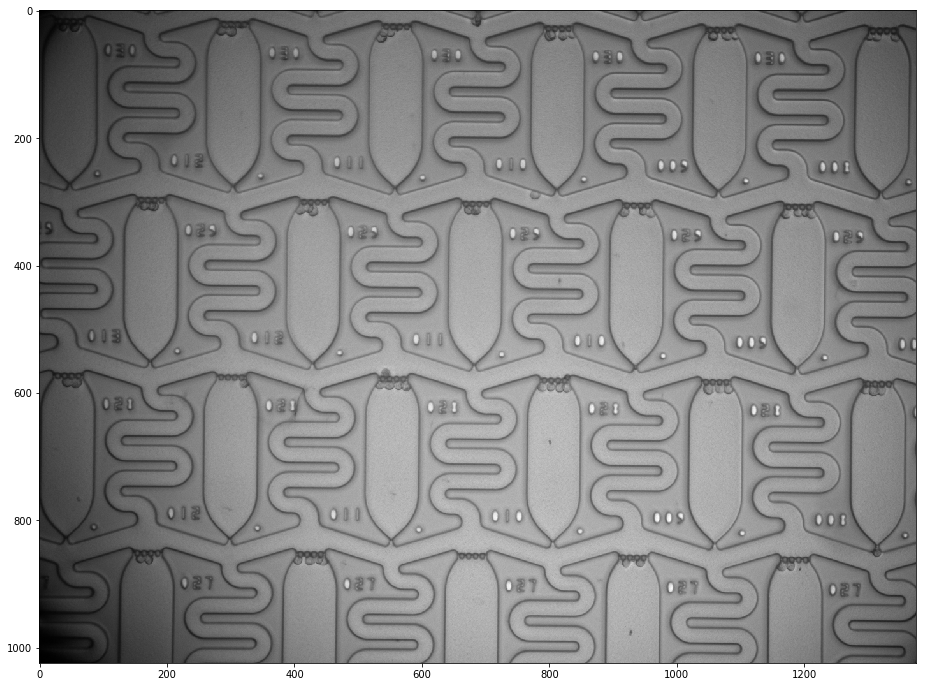

In [254]:
plt.imshow(dataset.load_image(1))
plt.gcf().set_size_inches(16, 12)

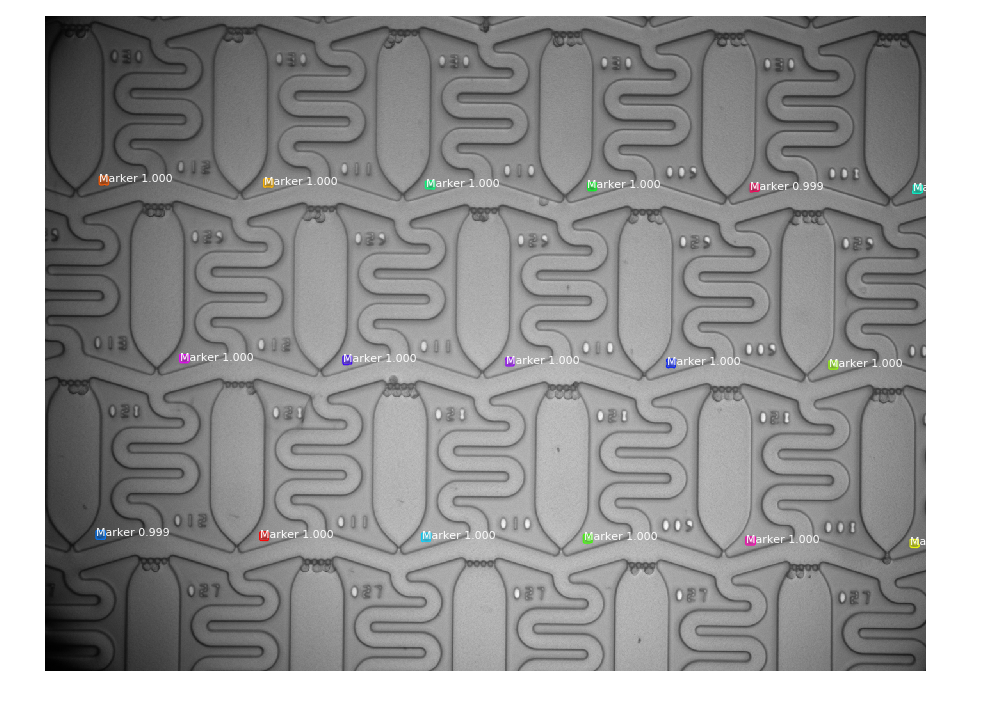

In [255]:
image_id = 1
image = dataset.load_image(image_id)
r = model.detect([image])[0]
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], show_bbox=False)

In [256]:
r['rois'].shape

(17, 4)

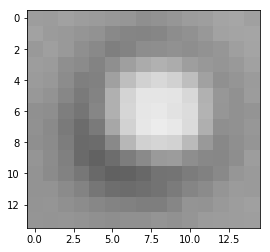

In [257]:
y1, x1, y2, x2 = r['rois'][0]
plt.imshow(image[y1:y2, x1:x2])

In [103]:
import imp
imp.reload(marker_ops)

<module 'celldom.marker' from '/lab/repos/celldom/python/source/celldom/marker.py'>

In [259]:
centers = marker_ops.get_marker_centers(image[..., 0], r['rois'])
centers.shape

(17, 2)

In [260]:
centers

y            x
0   542.309909   978.209045
1   544.830002  1231.391141
2   823.834229  1358.173437
3   537.306410   471.370018
4   816.498070   847.646353
5   814.443118   594.957232
6   812.371038   341.894755
7   819.963044  1102.313590
8   263.164564   600.957658
9   260.193335   347.819703
10  534.738309   216.905174
11  270.217525  1363.312101
12  539.816463   726.010800
13  256.230730    91.112480
14  265.680587   854.111940
15  810.272126    86.232116
16  267.717304  1108.301068

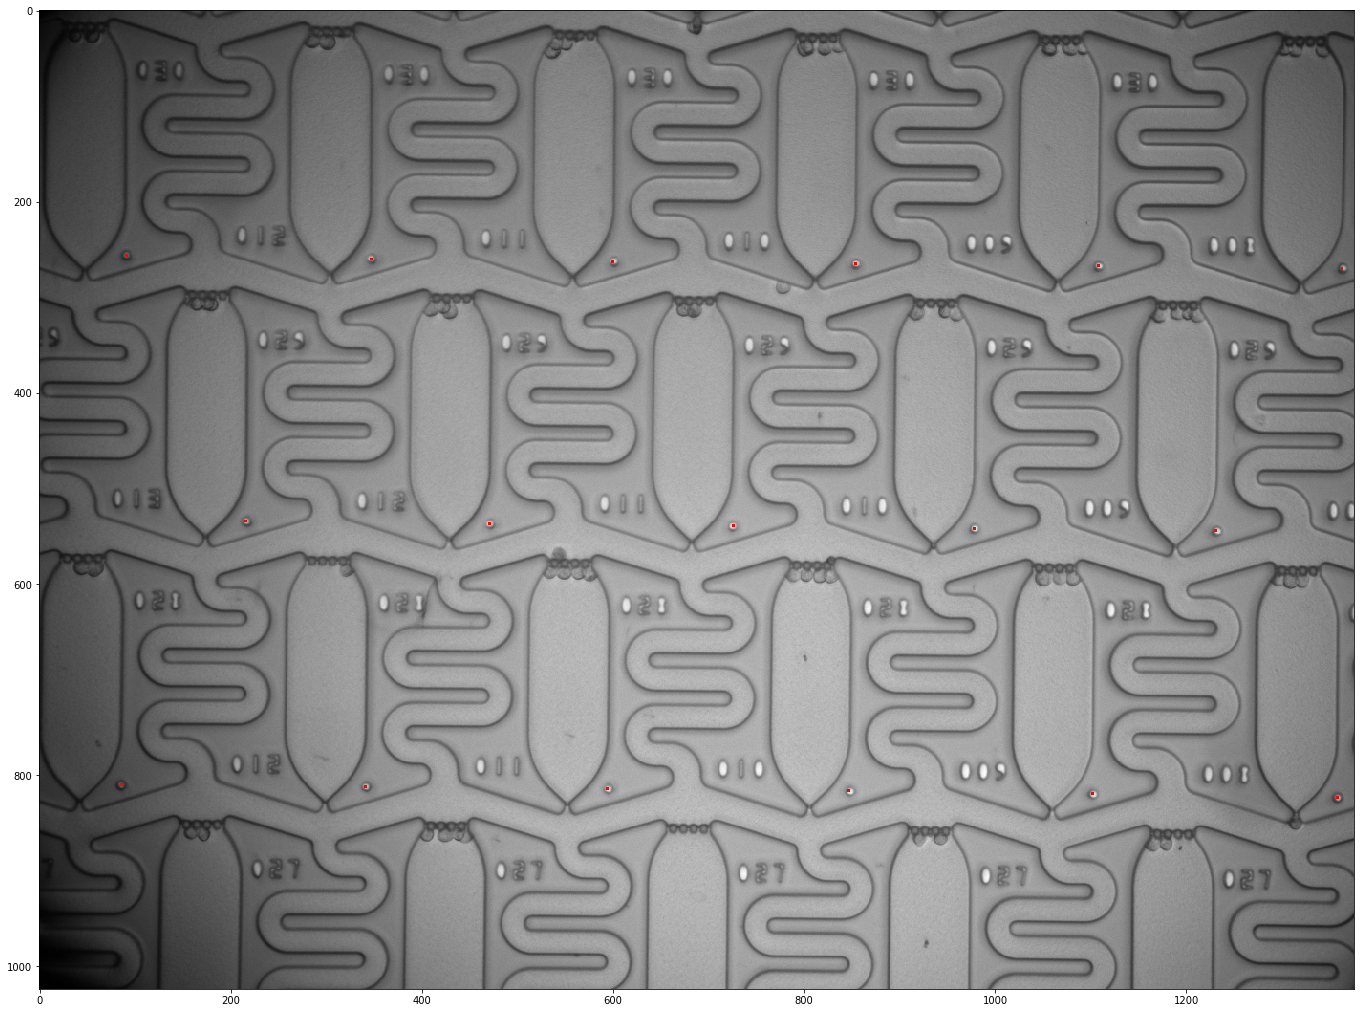

In [261]:
def visualize_marker_centers(img, centers, color=0):
    res = img.copy()
    for i, r in centers.astype(int).iterrows():
        rr, cc = draw.circle(r['y'], r['x'], radius=2, shape=img.shape)
        res[rr, cc] = color
    return res
    
plt.imshow(visualize_marker_centers(image, centers, [255, 0, 0]))
plt.gcf().set_size_inches(24, 18)

In [262]:
# def angle_between(p1, p2):
#     """Compute angle in degrees of vector from p1 to p2 (given in (y, x) form)
    
#     Args:
#         p1: A 2D point in (y, x) form
#         p2: A 2D point in (y, x) form
#     Return:
#         Angle in degrees between 0 and 180; angles are calculated in both the
#         clockwise and counter-clockwise direction and the minimum of those two
#         is returned
#     """
#     ang1 = np.arctan2(*(p1 - p2))
#     ang2 = np.arctan2(*(p2 - p1))
    
#     # These only return results in [0, 360]
#     ang_right = np.rad2deg(ang1 % (2 * np.pi))
#     ang_left = np.rad2deg(ang2 % (2 * np.pi))
#     return min(ang_right, ang_left)

def angle_between(p1, p2):
    """Compute angle of p2 - p1 vector in degrees
    
    Args:
        p1: A 2D point in (y, x) form
        p2: A 2D point in (y, x) form
    Return:
        Angle in degrees between -180 and 180
    """
    return np.rad2deg(np.arctan2(*(p2 - p1)))

angle_between(np.array([0, 0]), np.array([-.1, 1]))

-5.710593137499643

In [263]:
def get_marker_neighbors(centers, angle_range=(-25, 25)):
    if centers.ndim != 2:
        raise ValueError('Expecting centers to be 2D array (shape given = {})'.format(centers.shape))
    n_points = centers.shape[0]
    
    res = []
    for i in range(n_points):
        candidates = []
        for j in range(n_points):
            if i == j:
                continue
            
            point = centers[i]
            neighbor = centers[j]
            angle = angle_between(point, neighbor)
            
            if angle_range[0] <= angle <= angle_range[1]:
                distance = np.linalg.norm(neighbor - point)
                candidates.append((i, point[0], point[1], j, neighbor[0], neighbor[1], angle, distance))
            
        if not candidates:
            continue
        candidates = np.array(candidates)
        closest_idx = np.argsort(candidates[:, -1])[0]
        res.append(candidates[closest_idx])

    return pd.DataFrame(res, columns=['point_idx', 'point_y', 'point_x', 'neighbor_idx', 'neighbor_y', 'neighbor_x', 'angle', 'distance'])
            
    
neighbors = get_marker_neighbors(centers.values)          
neighbors

point_idx     point_y      point_x  neighbor_idx  neighbor_y   neighbor_x  \
0         0.0  542.309909   978.209045           1.0  544.830002  1231.391141   
1         3.0  537.306410   471.370018          12.0  539.816463   726.010800   
2         4.0  816.498070   847.646353           7.0  819.963044  1102.313590   
3         5.0  814.443118   594.957232           4.0  816.498070   847.646353   
4         6.0  812.371038   341.894755           5.0  814.443118   594.957232   
5         7.0  819.963044  1102.313590           2.0  823.834229  1358.173437   
6         8.0  263.164564   600.957658          14.0  265.680587   854.111940   
7         9.0  260.193335   347.819703           8.0  263.164564   600.957658   
8        10.0  534.738309   216.905174           3.0  537.306410   471.370018   
9        12.0  539.816463   726.010800           0.0  542.309909   978.209045   
10       13.0  256.230730    91.112480           9.0  260.193335   347.819703   
11       14.0  265.680587   854.111940          16.0  267.717304  1108.301068   
12       15.0  810.272126    86.232116           6.0  812.371038   341.894755   
13       16.0  267.717304  1108.301068          11.0  270.217525  1363.312101   

       angle    distance  
0   0.570285  253.194637  
1   0.564759  254.653153  
2   0.779512  254.690808  
3   0.465938  252.697477  
4   0.469128  253.070960  
5   0.866825  255.889131  
6   0.569426  253.166785  
7   0.672483  253.155392  
8   0.578219  254.477802  
9   0.566456  252.210571  
10  0.884364  256.737805  
11  0.459079  254.197287  
12  0.470370  255.671254  
13  0.561731  255.023290

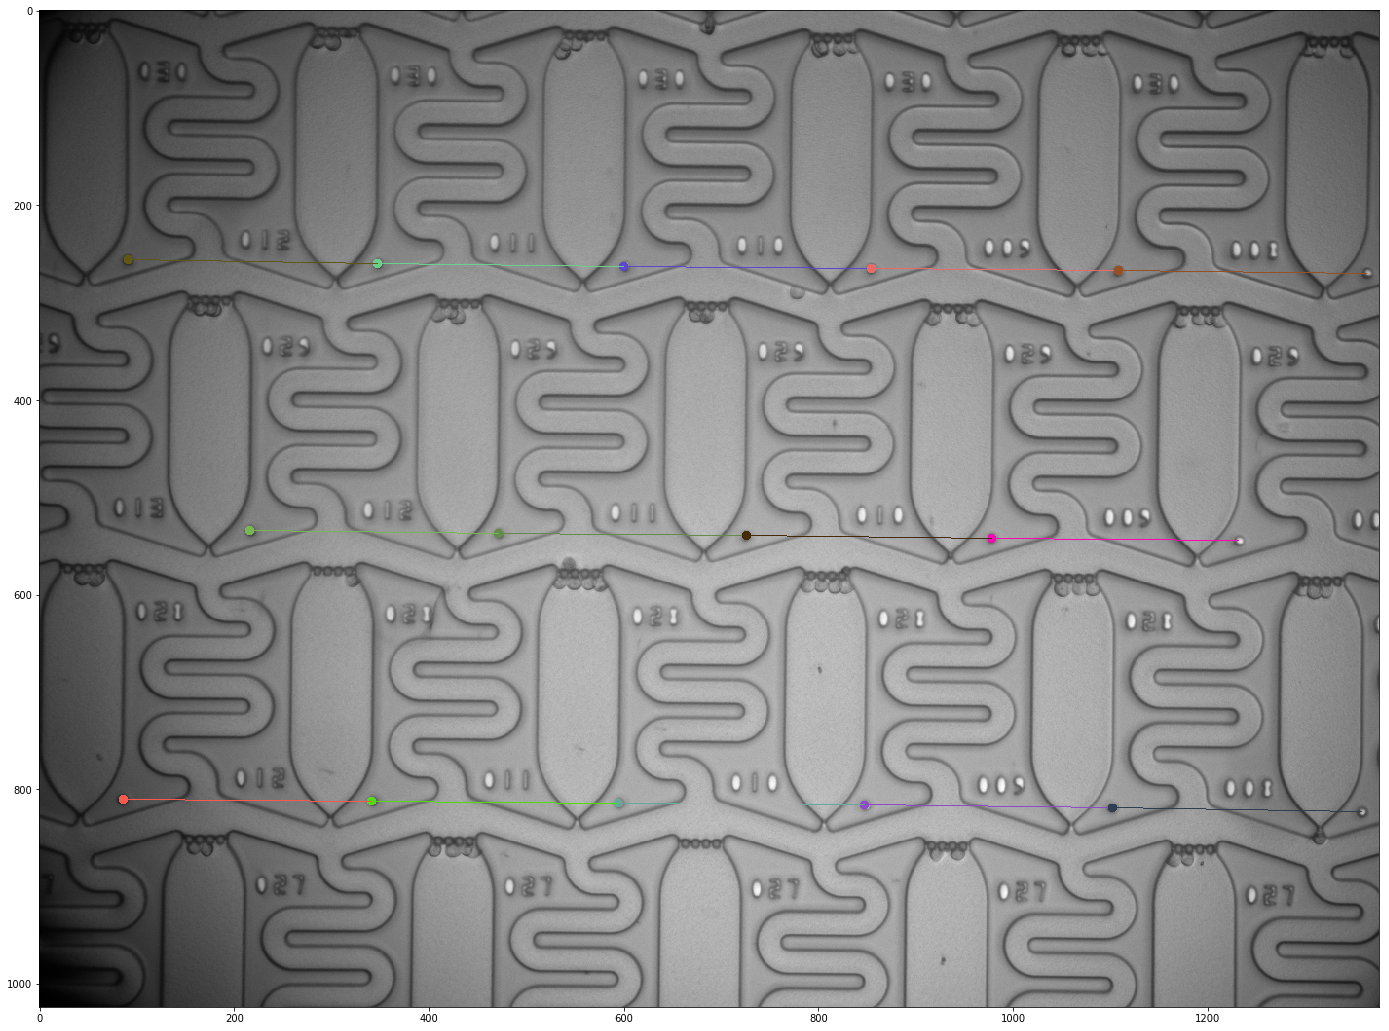

In [264]:
from skimage import draw

def visualize_neighbors(img, neighbors):
    res = img.copy()
    for i, r in neighbors.astype(int).iterrows():
        color = np.random.randint(0, 255, size=3)
        py, px = r['point_y'], r['point_x']
        ny, nx = r['neighbor_y'], r['neighbor_x']
        rr, cc = draw.line(py, px, ny, nx)
        res[rr, cc] = color
        
        rr, cc = draw.circle(py, px, radius=5, shape=img.shape)
        res[rr, cc] = color
    return res

plt.imshow(visualize_neighbors(image, neighbors))
plt.gcf().set_size_inches(24, 24)

In [265]:
def rotate_vectors_2d(arr, rotation, origin):
    assert arr.ndim == 2
    alpha = np.deg2rad(rotation)
    a = np.array([[np.cos(alpha), -np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]])
    arr = arr.T - origin.reshape(-1, 1)
    return (origin.reshape(-1, 1) + np.dot(a, arr)).T

In [266]:
from skimage import transform 

def apply_normalization(img, centers, rotation=None, scale=None):
    if rotation:
        img = transform.rotate(img, rotation)
        
        # Use same formula for origin as in transform.rotate
        origin = np.array(img.shape[:2]) / 2. - .5
        centers = pd.DataFrame(rotate_vectors_2d(centers[['y', 'x']].values, rotation, origin), index=centers.index, columns=centers.columns)
    if scale:
        img = transform.rescale(img, scale)
        centers = centers[['y', 'x']] * scale

    return img, centers

rotation, scale = neighbors['angle'].mean(), neighbors['distance'].mean()
norm_image, norm_centers = apply_normalization(image, centers, rotation=rotation, scale=None)

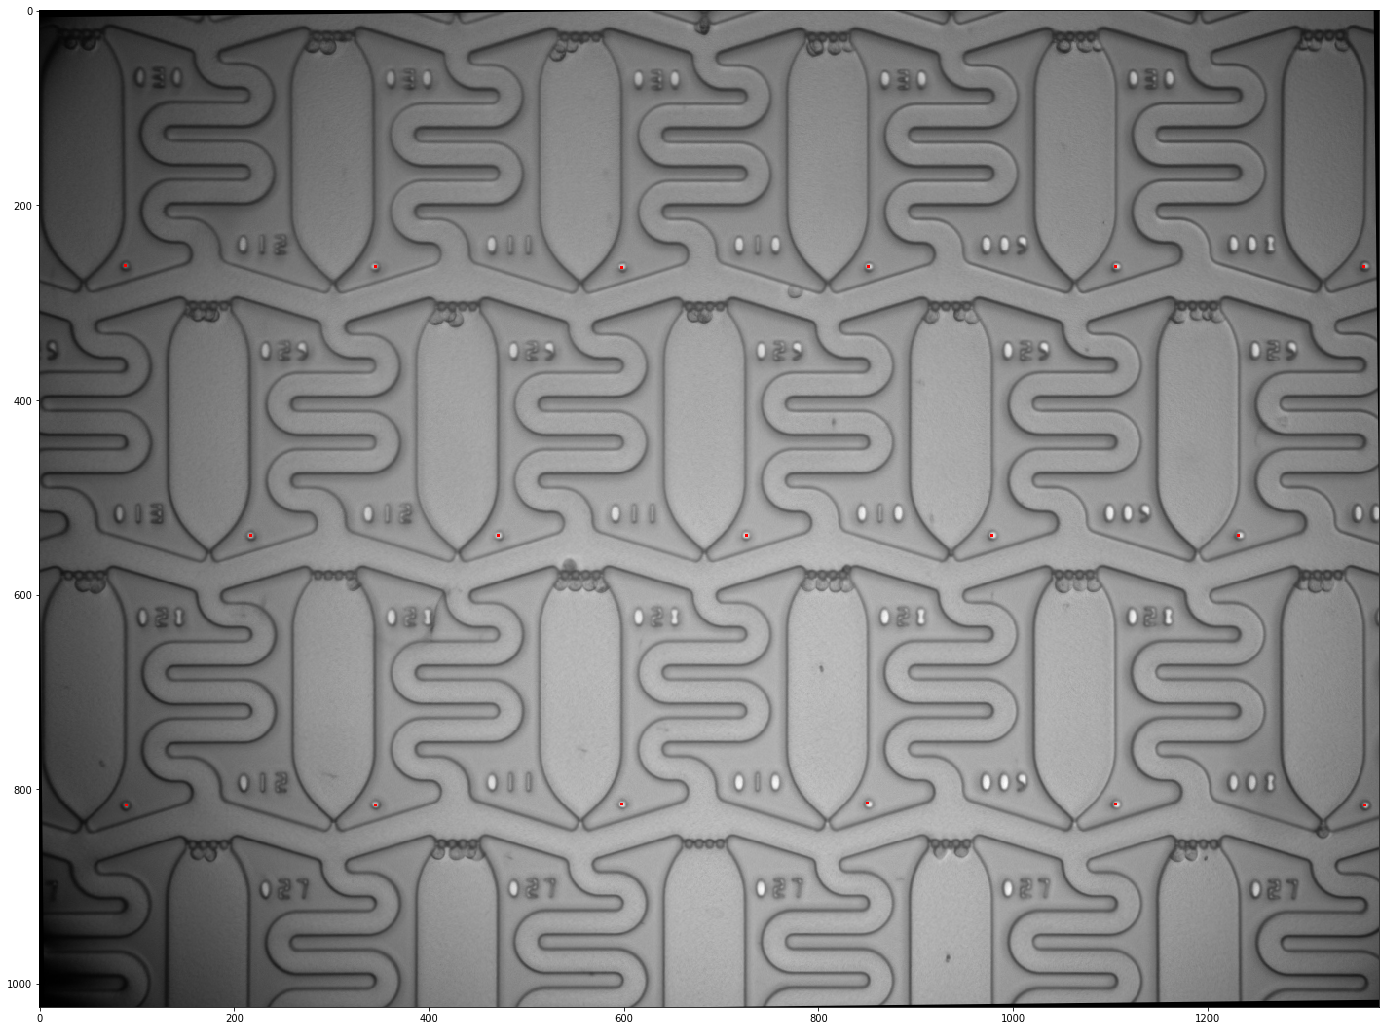

In [267]:
plt.imshow(visualize_marker_centers(norm_image, norm_centers, color=[1., 0, 0]))
plt.gcf().set_size_inches(24, 24)

In [319]:
chip_config = dict(
    apt_margins = dict(bottom=60, top=250, right=75, left=160),
    apt_num_margins = dict(bottom=-170, top=210, right=75, left=0)
)

In [320]:
def extract_around_marker(img, center, margins):
    cy, cx = center
    
    # Defining bounding box to crop out
    ymin = cy - margins['top']
    ymax = cy + margins['bottom']
    xmin = cx - margins['left']
    xmax = cx + margins['right']

    # Return nothing if any part of the box is outside the original image
    if xmin < 0 or ymin < 0 or xmax > img.shape[1] or ymax > img.shape[0]:
        return None
    
    img = img[ymin:ymax, xmin:xmax]
    assert np.all(np.array(img.shape) > 0)
    return img

def extract_images(img, centers, chip_config):
    imgs = []
    for i, r in centers.astype(int).iterrows():
        center = r['y'], r['x']
        
        apt_img = extract_around_marker(img, center, chip_config['apt_margins'])
        if apt_img is None:
            continue
            
        apt_num_img = extract_around_marker(img, center, chip_config['apt_num_margins'])
        if apt_num_img is None:
            continue
        
        imgs.append((center, apt_img, apt_num_img))
    return imgs

apt_images = extract_images(norm_image, norm_centers, chip_config)

In [321]:
len(apt_images)

13

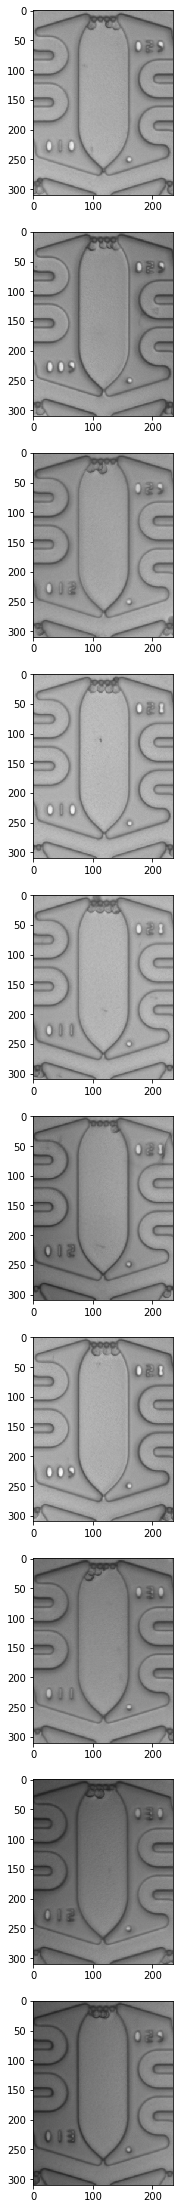

In [402]:
n_img = 10
fig, axs = plt.subplots(n_img, 1)
fig.set_size_inches(8, 4 * n_img)
for i in range(n_img):
    axs[i].imshow(apt_images[i][1])

### Experiments with Digit Classifiers

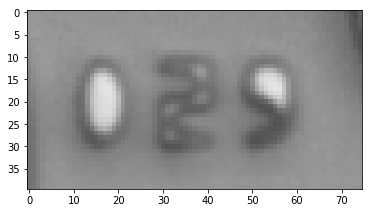

In [323]:
digits_img = apt_images[0][2]
plt.imshow(digits_img)

In [327]:
import keras
svhn_model_path = '/lab/data/celldom/model/pretrained/svhn_classifier.h5'
# predict image classes
#def predict(model, img_path, batch_size):
#     img_generator = image.ImageDataGenerator(preprocessing_function=lambda img: img/255.0)
#     validation_generator = img_generator.flow_from_directory(directory=img_path, target_size=(32,32), shuffle=False,
#                                                              batch_size=batch_size, color_mode="rgb")

digit_model = keras.models.load_model(svhn_model_path)

In [338]:
digits_img.shape

(40, 75, 3)

In [400]:
from skimage import filters
from skimage import util as skutil
from skimage import color

#prep_digits_img = digits_img.copy()[:, 10:25]
#prep_digits_img = digits_img.copy()[:, 23:45]
prep_digits_img = digits_img.copy()[5:35, 45:62]

prep_digits_img = skutil.invert(prep_digits_img)[..., 0]
#prep_digits_img = prep_digits_img[..., 0]
prep_digits_img = (prep_digits_img > filters.threshold_otsu(prep_digits_img)).astype(float)
prep_digits_img = color.gray2rgb(prep_digits_img)
prep_digits_img = transform.resize(prep_digits_img, (32, 32, 3), mode='constant')
prep_digits_img = np.expand_dims(prep_digits_img, 0)
prep_digits_img.shape, prep_digits_img.min(), prep_digits_img.max()

((1, 32, 32, 3), 0.0, 1.0)

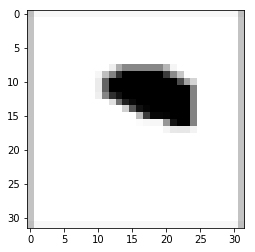

In [401]:
plt.imshow(prep_digits_img[0])

In [395]:
digit_model.predict(prep_digits_img)

array([[1.3198157e-01, 1.8751936e-03, 1.0703078e-02, 1.8617660e-03,
        1.2694721e-01, 1.2112771e-03, 4.6042319e-02, 3.4228619e-04,
        2.3379718e-01, 4.4523808e-01]], dtype=float32)